In [1]:
import torch
import gplearn.genetic as gp
from gplearn.functions import make_function
import numpy as np
import matplotlib.pyplot as plt
from utils import std_anim, save_img, plot_tree, set_IO, get_animation, save_model, load_model, create_folder
from classes_games import GameOfLife, FakeGameOfLife, Node, FakeGameOfLife9Var, FakeGameOfLife9VarFeature, FasterGameOfLife
# # import animation
import matplotlib.animation as animation
torch.random.manual_seed(42)

create_folder("Presentation")
%cd Presentation
create_folder("Images")
create_folder("Models")
create_folder("Simulations")

/home/utente/Scrivania/DS_SC/3rd_SEM/Global_Multi_Objective_Optimization/Experiments/gp_game_of_life/Presentation


### Introduction: Game of Life
The Conway's Game of Life is a cellular automaton devised by the British mathematician John Horton Conway in 1970. It is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. 

One interacts with the Game of Life by creating an initial configuration and observing how it evolves.

The domain of the Game of Life is a 2 dimensional grid of cells that can be either alive or dead. 
The evolution of the grid is determined by the following rules:
* Any live cell with fewer than two live neighbours dies, as if caused by underpopulation.
* Any live cell with two or three live neighbours lives on to the next generation.
* Any live cell with more than three live neighbours dies, as if by overpopulation.
* Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

The objective of this work is to apply tree-based GP to the Game of Life problem. The GP will be used to evolve programs that will generate the next state of the grid given the current state.

A possible representation of the correct set of rules can be defined from scratch


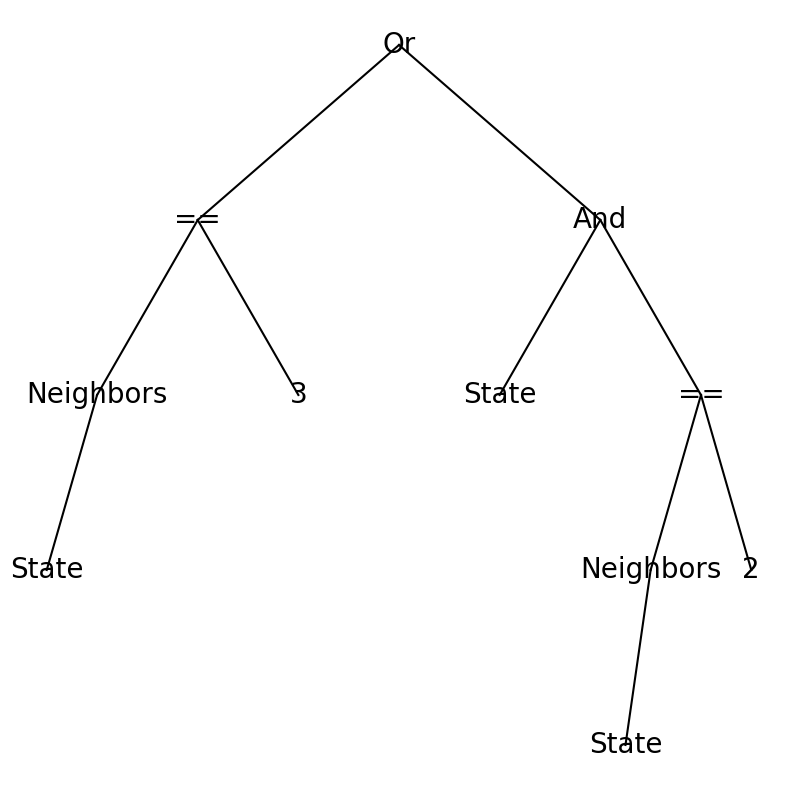

In [2]:
''' 

State can be 0 (dead) or 1 (alive)
    the terminal set is the set of all possible states

t_set = ("State", 2, 3)
    the function set is the set of all possible operations

f_set = ("And", "Or", "==", "Neighbors") # Neighbors is a function that returns the number of neighbors of the current state

'''

# build the tree
n = Node("Neighbors")
n.add_left(Node("State"))
n = Node("==").add_left(n).add_right(Node(3))
t = Node("Neighbors").add_left(Node("State"))
t = Node("==").add_left(t).add_right(Node(2))
t = Node("And").add_left(Node("State")).add_right(t)
n = Node("Or").add_left(n).add_right(t)

fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(n, ax, 0, 0, 1, 1)
save_img("scratch_tree")
plt.show()

### Initialize the game of life (built in Pytorch)

In [3]:
game = GameOfLife(M=10, N=10)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [4]:
game.step()
print(f"State of the game at time 1: \n{game.state}\n")
print(f"Neighbors at time 0: \n{game.neighbors}\n")

State of the game at time 1: 
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 1, 1, 1, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 0, 1, 1, 1, 1, 0, 0, 1],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]], dtype=torch.int32)

Neighbors at time 0: 
tensor([[0, 0, 0, 0, 0, 1, 0, 2, 2, 1],
        [1, 2, 1, 2, 2, 3, 3, 3, 3, 3],
        [1, 3, 1, 2, 1, 1, 2, 1, 3, 1],
        [2, 2, 2, 2, 3, 3, 3, 1, 3, 2],
        [2, 3, 2, 1, 1, 0, 1, 0, 2, 1],
        [1, 3, 1, 1, 1, 1, 2, 2, 5, 3],
        [2, 2, 3, 3, 3, 3, 3, 2, 3, 2],
        [3, 3, 4, 2, 3, 2, 3, 5, 5, 3],
        [1, 1, 3, 3, 6, 5, 4, 2, 2, 2],
        [2, 2, 2, 2, 2, 1, 2, 2, 3, 1]], dtype=torch.int32)



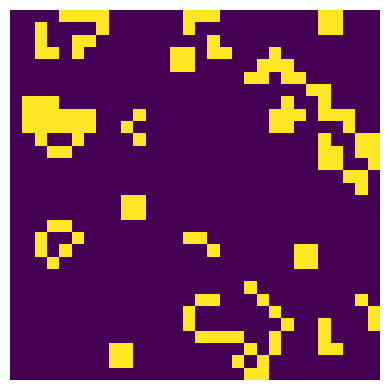

In [5]:
# animate the game of life
game = GameOfLife(M=30, N=30)
vid = std_anim(game, figsize=(4, 4), frames=20, interval=60, title=False, autolayout=True)
save_img("scratch_gof")
plt.show()

In [6]:
vid

### Create train-test data 
In this example, I've used a 2-dimensional input (state, neighbors) and a 1-dimensional output (dead/alive)

Notice that in this way it's like "cheating", that's because:
* There is an handcrafted feature engineering (we are fixing the relation between neighbors)
* The problem is relatively simple to solve because the sample space is small (only 2*8=16 possible states)

### Assumptions
* The time series depends only on the previous state
* The time series is stationary
* The time series is deterministic
* The spatial relation between the cells is fixed and it's the same for all the cells
* The spatial relation between the cells is local (only the neighbors are relevant, where the neighbors are the cells in the box outside the cell)

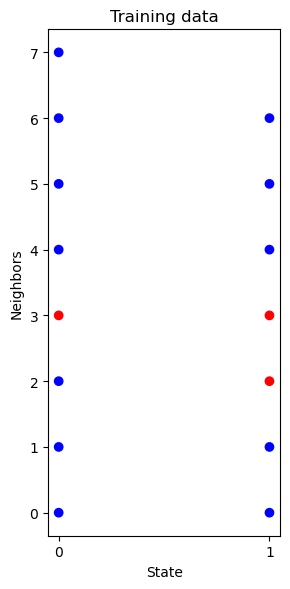

In [7]:
torch.manual_seed(42)
game = GameOfLife(M=22, N=22)

# build the train set
x_train, y_train = set_IO(game)

# plot a scatter plot of the training data
# set the figsize
plt.figure(figsize=(3, 6))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="bwr")
plt.ylabel("Neighbors")
plt.xlabel("State")
plt.xticks([0, 1])
plt.title("Training data")
save_img("naive_training_data_scatter_model1")
plt.show()

In [8]:
print(f"input train shape: {x_train.shape}\noutput train shape: {y_train.shape}")
print(f"\ninput train: \n{x_train}\noutput train: {y_train}")

input train shape: (15, 2)
output train shape: (15,)

input train: 
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [1 0]
 [1 1]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]]
output train: [0 0 0 1 0 0 0 0 0 0 1 1 0 0 0]


### Use gp.SymbolicClassifier to learn the game of life
In this case, remember that the input is a 2-dimensional array and the output is a 1-dimensional array.

I've supposed that the rules are hidden, so I've chosen the default function set

In [9]:
# # add the functions to the function set
function_set = ('add', 'sub', 'mul', 'div')
max_gen = 100

sc = gp.SymbolicClassifier(population_size=500,
                            generations=max_gen, stopping_criteria=0.01, init_depth=(3, 8),
                            p_crossover=0.7, p_subtree_mutation=0.1,
                            const_range=(0, 1), init_method='half and half',
                            p_hoist_mutation=0.1, p_point_mutation=0.05,
                            parsimony_coefficient=0.008, random_state=42,
                            verbose=1,
                            function_set=function_set, warm_start=False)

sc.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   114.51          3.67898       31         0.390439              N/A      2.76m
   1    16.60          1.12188       31         0.378649              N/A     52.65s
   2     9.68          0.98473       25         0.348811              N/A     47.99s
   3     9.95         0.847345       25         0.348811              N/A     43.41s
   4     8.48         0.811123       17         0.345933              N/A     41.64s
   5     7.47         0.739055       17         0.311411              N/A     42.35s
   6    12.79         0.841476       21         0.303197              N/A     42.70s
   7    16.81         0.767221       33         0.292721              N/A     36.70s
   8    16.92         0.796343       21         0.303197              N/A  

SymbolicClassifier(const_range=(0, 1), generations=100, init_depth=(3, 8),
                   p_crossover=0.7, p_hoist_mutation=0.1, p_point_mutation=0.05,
                   p_subtree_mutation=0.1, parsimony_coefficient=0.008,
                   population_size=500, random_state=42, stopping_criteria=0.01,
                   verbose=1)

In [10]:
# save the SymbolicClassifier model with naive variables
# save_model(sc, "naive_model1")

# load the model
sc = load_model("naive_model1")

As we can notice, we've obtained a good tree in only 30 generations!

By doing more experiments I've discovered that with this code we obtain a tree that uses only add, sub and mul as effective fset (3 functions are sufficient to describe the dynamics)

The drawback is that in this way the tree is deeper and a bit slower in the inference phase (so we keep the tree obtained before)

In [11]:
# function_set = ('add', 'sub', 'mul', 'max', 'min')
# max_gen = 1000

# sc = gp.SymbolicClassifier(population_size=500,
#                             generations=max_gen, stopping_criteria=0.01, init_depth=(2, 6),
#                             p_crossover=0.70, p_subtree_mutation=0.1,
#                             const_range=(0, 1), init_method='half and half',
#                             parsimony_coefficient=0.005,
#                             p_hoist_mutation=0.1, p_point_mutation=0.05,
#                             random_state=42,
#                             verbose=1,
#                             function_set=function_set, warm_start=False)

# sc.fit(x_train, y_train)

### Contour plot of the learned function
Notice how difficult is for our classifier to learn a simple problem like this

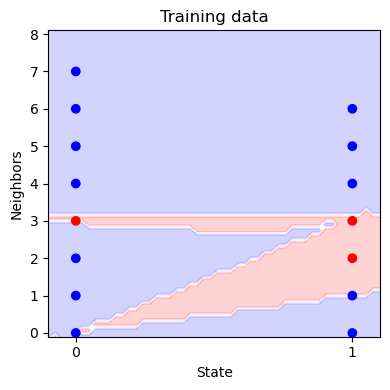

In [12]:
# create a meshgrid
y = np.linspace(-0.1, 8.1, 50)
x = np.linspace(-0.1, 1.1, 50)
X, Y = np.meshgrid(x, y)
# predict the values for the meshgrid

Z = sc.predict(np.c_[X.ravel(), Y.ravel()])

# plot the decision boundary
plt.contourf(X, Y, Z.reshape(X.shape), cmap="bwr", alpha=0.2)
plt.figsize=(3, 6)
# plot the training data
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="bwr")
plt.ylabel("Neighbors")
plt.xlabel("State")
plt.xticks([0, 1])
plt.title("Training data")
save_img("contourplot_model1")
plt.show()

Watching the plot, we can see that the boundaries are not so clear, so we could try to increase the number of generations.
However, we must remember that's a dynamical system in a discrete domain, so if we apply the obtained tree we notice that the results are perfect (we can fully reproduce the game of life)

Let's play a bit with the interact plot

In [13]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# # add the functions to the function set
function_set = ('add', 'sub', 'mul', 'div')
predicted_data = []
max_gen = 40

sc_vid = gp.SymbolicClassifier(population_size=500,
                            generations=max_gen, stopping_criteria=0.01, init_depth=(3, 8),
                            p_crossover=0.7, p_subtree_mutation=0.1,
                            const_range=(0, 1), init_method='half and half',
                            p_hoist_mutation=0.1, p_point_mutation=0.05,
                            parsimony_coefficient=0.008, random_state=42,
                            verbose=0,
                            function_set=function_set, warm_start=True)

k = 5

for i in range(0, max_gen+1, k):
    x = np.linspace(-0.1, 1.1, 50)
    y = np.linspace(-0.1, 8.1, 50)
    X, Y = np.meshgrid(x, y)

    sc_vid.set_params(generations=i+1)
    sc_vid.fit(x_train, y_train)
    predicted_data.append(sc_vid.predict(np.c_[X.ravel(), Y.ravel()]).reshape(X.shape))

def print_results(i):
    # plot the decision boundary
    plt.contourf(X, Y, predicted_data[i], cmap="bwr", alpha=0.5)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="bwr")
    plt.ylabel("Neighbors")
    plt.title(f"Generation {i*k}")
    plt.xlabel("State")
    plt.show()


interact(print_results, i=widgets.IntSlider(min=0,max=max_gen//k,value=0))

interactive(children=(IntSlider(value=0, description='i', max=8), Output()), _dom_classes=('widget-interact',)…

<function __main__.print_results(i)>

### Tree representation of the learned function

As we can see below, it's possible to learn a program that reproduce the game of life, however the tree is not so clear and it's not easy to understand the rules.

Moreover, the tree is bigger than the one defined from scratch, so it could be not so efficient.

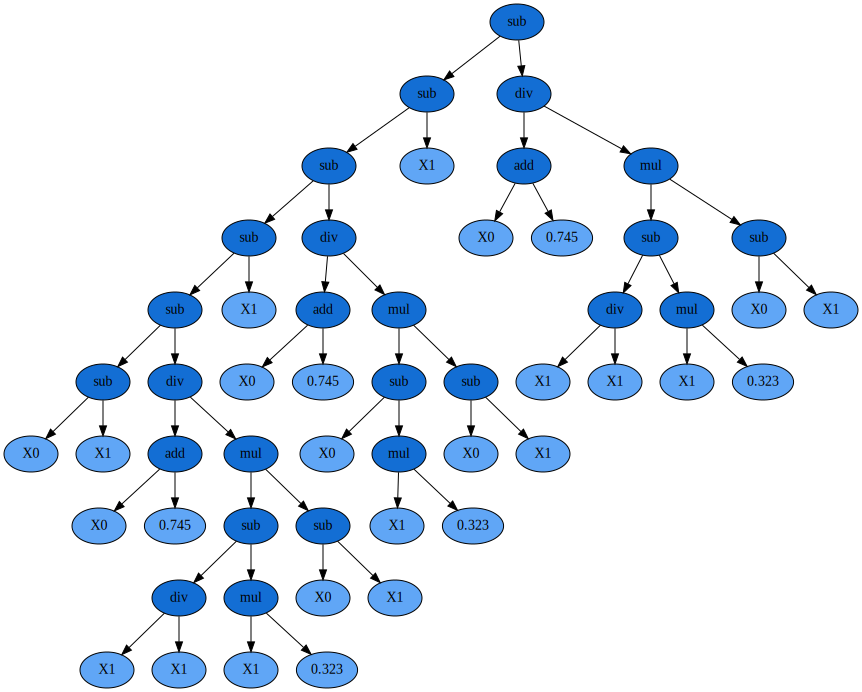

In [14]:
# represent the best program as a tree
g = sc._program.export_graphviz()
import graphviz
from graphviz import Source

# save the tree as a png
graph = graphviz.Source(g)
graph.render("Images/tree_model1", view=False, format="png")

# print the tree
Source(g)

### Fake Game Of Life
Now that we have the learned rules, we can build a "fake game of life" and see how it evolves

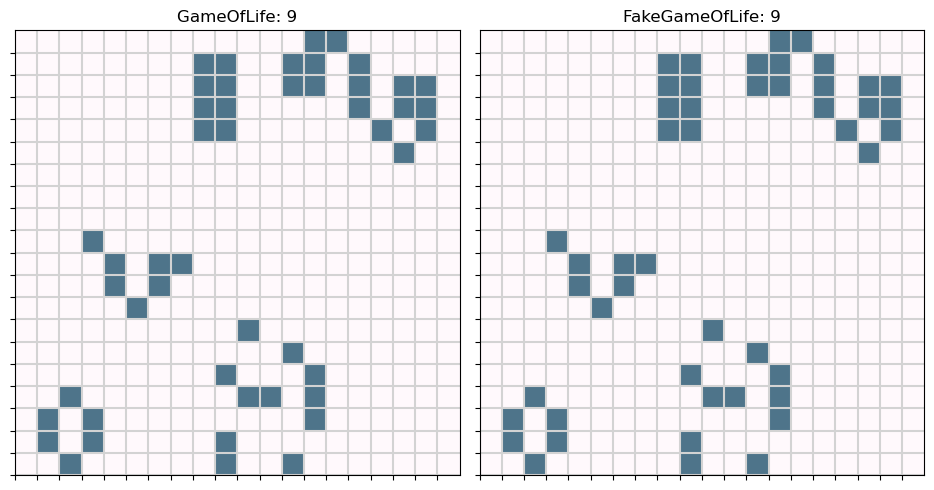

In [15]:
# create a game of life
torch.manual_seed(42)
gol = GameOfLife(M=20, N=20)
f_gol = FakeGameOfLife(state=gol.state, rule=sc)

# animate both games
# create the figure
fig, (ax1, ax2) = plt.subplots(1, 2)
# set the size of the figure
fig.set_size_inches(10, 5)

# create the video
ani = get_animation((gol, f_gol), fig, (ax1, ax2), interval=60, frames=10)
# save the video
ani.save("Simulations/game_of_life_vs_learned one.mp4")

In order to see if all the cells are equal, we can also plot the accuracy between the 2 simulations and see if it is set always to 1

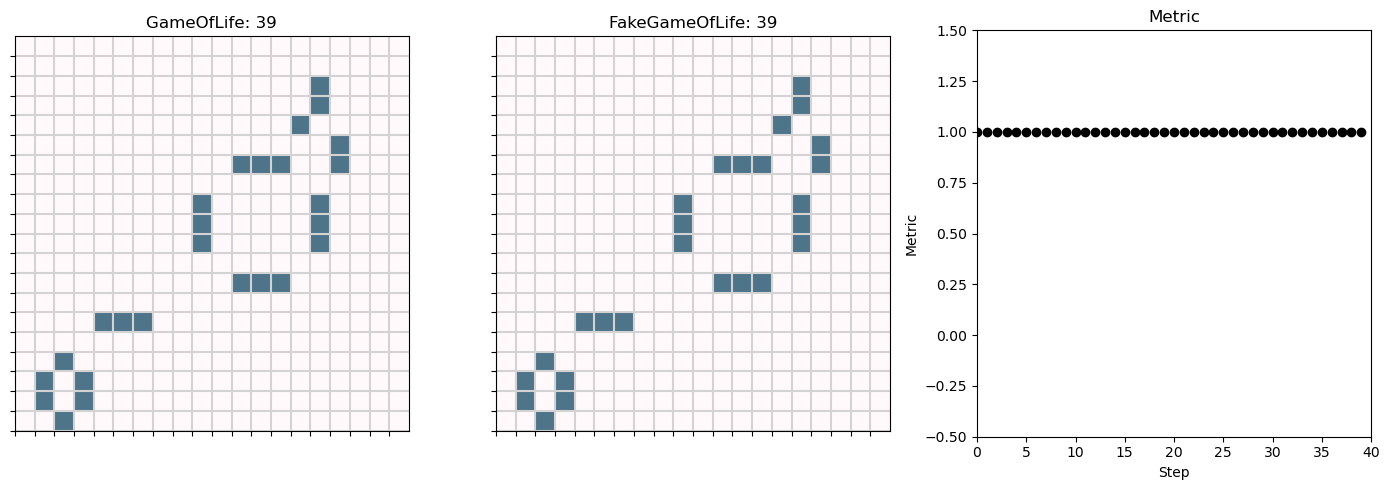

In [16]:
torch.manual_seed(42)
gol = GameOfLife(M=20, N=20)
f_gol = FakeGameOfLife(state=gol.state, M=20, N=20, rule=sc)

# define a metric to measure the difference between the two games
def metric(gol, f_gol):
    return 1-torch.mean(torch.abs(gol.state - f_gol.state), dtype=torch.float).item()


# concatenate a figure with 2 subplots with a line plot to show the metric
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
# create the video
ani = get_animation((gol, f_gol), fig, (ax1, ax2, ax3), interval=100, frames=40, metric=metric)
# save the video
ani.save("Simulations/game_of_life_metric.mp4")

### Extending the fset
Now, we want to see what happens if we add some functions to our fset, in particular the and, or and equal functions

This experiment uses a sufficient function set to learn the game of life in the same way we built the tree from scratch.

In this case, we use a SymbolicRegressor, because we don't want to transform the tree using the sigmoid function.

In [17]:
# define the and function in the integer domain
def _integer_and(x, y):
    if (x*y).any():
        return np.ones(x.shape, dtype=np.int8)
    return np.zeros(x.shape, dtype=np.int8)

def _integer_or(x, y):
    if (x+y).any():
        return np.ones(x.shape, dtype=np.int8)
    return np.zeros(x.shape, dtype=np.int8)

def _integer_eq(x, y):
    if (x.astype(np.int8) == y.astype(np.int8)).any():
        return np.ones(x.shape, dtype=np.int8)
    return np.zeros(x.shape, dtype=np.int8)

def _integer_not(x):
    if x.any()>0.5:
        return np.zeros(x.shape, dtype=np.int8)
    return np.ones(x.shape, dtype=np.int8)

def _int(x):
    return x.astype(np.int8)

i_and = make_function(function=_integer_and,
                        name='i_and',
                        arity=2)

i_or = make_function(function=_integer_or,
                        name='i_or',
                        arity=2)

i_eq = make_function(function=_integer_eq,
                        name='i_eq',
                        arity=2)
i_not = make_function(function=_integer_not,
                        name='i_not',
                        arity=1)

i_int = make_function(function=_int,
                        name='int',
                        arity=1)

In [18]:
# we use it if we want balanced labels
def set_IO_balanced(game:GameOfLife, unique=True):
    # s = np.array([game.state[i, j] for i in range(1, game.state.shape[0]-1) for j in range(1, game.state.shape[1]-1)], dtype=np.int8)
    s = game.state.flatten().numpy().astype(np.int8)
    ngbs = game.neighbors.flatten().numpy().astype(np.int8)
    s = np.concatenate((s.reshape(-1, 1), ngbs.reshape(-1, 1)), axis=1)
    game.step()
    y = game.state.flatten().numpy().astype(np.int8)
    if unique:
        unique_idx = np.unique(s, axis=0, return_index=True)[1]
        s = s[unique_idx]
        y = y[unique_idx]
        # balance the dataset
        idx_0 = np.where(y==0)[0]
        idx_1 = np.where(y==1)[0]
        if len(idx_0) > len(idx_1):
            idx_1 = np.random.choice(idx_1, len(idx_0))
        else:
            idx_0 = np.random.choice(idx_0, len(idx_1))
        idx = np.concatenate((idx_0, idx_1))
        s = s[idx]
        y = y[idx]
        print(y)
        
    return s, y

In [19]:
# function_set = ('add', 'mul', i_and, i_or, i_eq, i_int, 'max', 'min')
# max_gen = 100

# # x_train2, y_train2 = set_IO_balanced(GameOfLife(M=40, N=40), unique=True)

# sc_ext = gp.SymbolicRegressor(population_size=500, tournament_size=30,
#                             generations=max_gen, stopping_criteria=0.01, init_depth=(2, 5),
#                             p_crossover=0.70, p_subtree_mutation=0.1,
#                             const_range=None, init_method='half and half',
#                             p_hoist_mutation=0.1, p_point_mutation=0.1,
#                             parsimony_coefficient=0.001, random_state=42,
#                             verbose=1,
#                             function_set=function_set, warm_start=False)

# sc_ext.fit(x_train, y_train)

In [20]:
# save the models
# save_model(sc_ext, "failed_symbolic_classifier_extended_fset")
sc_ext = load_model("failed_symbolic_classifier_extended_fset")

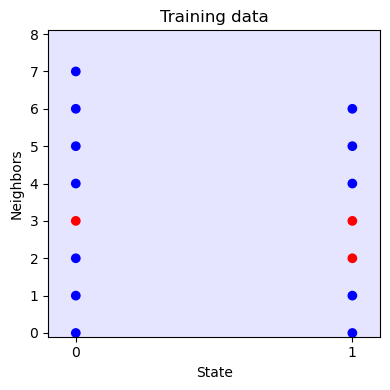

In [21]:
# create a meshgrid
y = np.linspace(-0.1, 8.1, 50)
x = np.linspace(-0.1, 1.1, 50)
X, Y = np.meshgrid(x, y)
# predict the values for the meshgrid

Z = sc_ext.predict(np.c_[X.ravel(), Y.ravel()])

# plot the decision boundary
plt.contourf(X, Y, Z.reshape(X.shape), cmap="bwr", alpha=0.2)
# plot the training data
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="bwr")
plt.ylabel("Neighbors")
plt.xlabel("State")
plt.xticks([0, 1])
plt.title("Training data")
save_img("countourplot trivial_prediction")
plt.show()

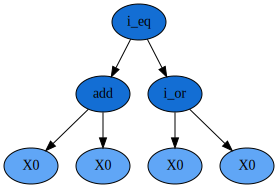

In [22]:
# represent the best program as a tree
g_ext = sc_ext._program.export_graphviz()
import graphviz
from graphviz import Source

# save the tree as image
graph = graphviz.Source(g_ext)
graph.render("Images/trivial_prediction_tree.png")

# print the tree
Source(g_ext)

The issue of learning the problem in this way is that it's more difficult to reduce the loss (we are now in a discrete output, so the landscape is mostly flat)

So, from a theoretical point of view the solution exist (also in a more compact way than in the SymbolicClassifier with standard fset), but it's more difficult to find it.

### Extended input: 9 variables
Now, we want to relax the assumption done to compute the neighbors, in particular we want to consider the 8 neighbors and the cell itself.

In [23]:
# in this case, we consider the interaction with neghbors as hidden
def set_IO2(game:GameOfLife, unique=True):
    # s = np.array([game.state[i, j] for i in range(1, game.state.shape[0]-1) for j in range(1, game.state.shape[1]-1)], dtype=np.int8)
    s = np.array([game.state[k-1:k+2, j-1:j+2].flatten().numpy().astype(np.int8) for k in range(1, game.state.shape[0]-1) for j in range(1, game.state.shape[1]-1)])    
    # concatenate the state with the number of neighbors
    # neigh = np.array([np.concatenate((game.state[k-1, j-1:j+2].flatten().numpy().astype(np.int8), 
    #                                   game.state[k, j-1].flatten().numpy().astype(np.int8),
    #                                   game.state[k, j+1].flatten().numpy().astype(np.int8),
                                    #   game.state[k+1, j-1:j+2].flatten().numpy().astype(np.int8))) for k in range(1, game.state.shape[0]-1) for j in range(1, game.state.shape[1]-1)])

    game.step()
    y = game.state[1:-1, 1:-1].flatten().numpy().astype(np.int8)
    if unique:
        unique_idx_train = np.unique(s, axis=0, return_index=True)[1]
        s = s[unique_idx_train]
        y = y[unique_idx_train]
        
    return s, y

torch.manual_seed(42)
x_train2, y_train2 = set_IO2(GameOfLife(M=220, N=100)) # it can be hugely optimized
      
x_test2, y_test2 = set_IO2(GameOfLife(M=7, N=7))

Here we want to notice how the number of neighbors are distributed in the grid

input train shape: (503, 9)
output train shape: (503,)

input test shape: (24, 9)
output test shape: (24,)


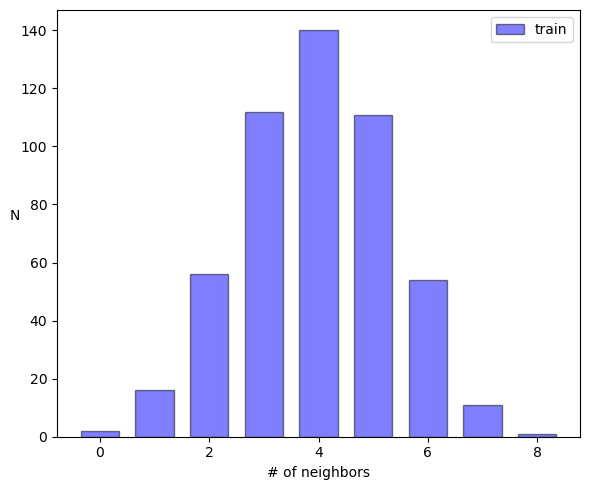

In [24]:
print(f"input train shape: {x_train2.shape}\noutput train shape: {y_train2.shape}")
print(f"\ninput test shape: {x_test2.shape}\noutput test shape: {y_test2.shape}")
# print(f"\ninput train: \n{x_train2}\noutput train: {y_train2}\nneigh train: {neigh_train2}")

def to_features(x):
    s = x[:, 4], np.sum(x, axis=1) - x[:, 4]
    return np.column_stack(s)

# plot the frequency of the number of neighbors
# set the figure size
plt.figure(figsize=(6, 5))
# get the unique values with their frequency
unique, counts = np.unique(to_features(x_train2)[:, 1], return_counts=True)
# plot the frequency of the number of neighbors
plt.bar(unique, counts, color="b", alpha=0.5, width=0.7, edgecolor="k", linewidth=1, label="train")
plt.xlabel("# of neighbors")
plt.ylabel("N", rotation=0)
plt.legend()
save_img("distribution_neighbors")
plt.show()

### Extended model: 9 dummy variables

In [25]:
# add the functions to the function set
# function_set = ('add', 'sub', 'mul', 'max', 'min')

# max_gen2 = 2000

# sc2_hard = gp.SymbolicClassifier(population_size=600,
#                             generations=max_gen2, stopping_criteria=0.01, init_depth=(2, 8),
#                             p_crossover=0.7, p_subtree_mutation=0.1,
#                             const_range=(0, 1), init_method='half and half',
#                             p_hoist_mutation=0.1, p_point_mutation=0.05,
#                             parsimony_coefficient=0.001, random_state=42,
#                             verbose=1,
#                             function_set=function_set, warm_start=False)

# sc2_hard.fit(x_train2, y_train2)

As we notice, the learning procedure is more difficult than before, moreover we could have problems with the balance of the dataset (it could be more difficult to learn the rules when the number of neighbors is near the tails of the distribution)

### Features trick
As we've seen, learning the game of life with the extended input is more difficult than with the standard input.

However, we can try to use a trick to make the problem easier -> we reduce the complexity of the problem using a Symbolic Transformer.

In [26]:
# # # add the functions to the function set
# function_set = ('add', 'sub', 'mul', 'div')
# max_gen1 = 50
# # build a symbolic transformer to perform automatic feature engineering, then fit and transform the training data
# st = gp.SymbolicTransformer(generations=max_gen1, population_size=1000,
#                             hall_of_fame=100, n_components=2,
#                             function_set=function_set,
#                             parsimony_coefficient=0.0005,
#                             max_samples=0.9, verbose=1,
#                             random_state=42, n_jobs=4)
# st.fit(x_train2, y_train2)

In [27]:
# in this case, I load a pretrained model
st = load_model("Symbolic Transformer 9 to 2")

Shape of train set: (17, 2)


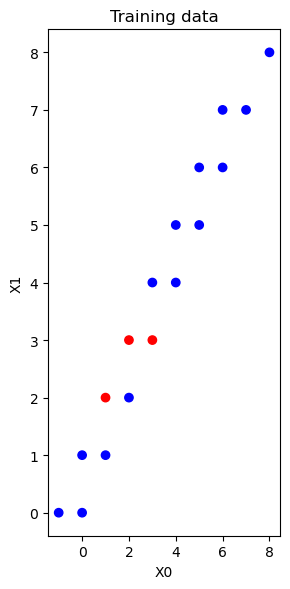

In [28]:
x_train2 = st.transform(x_train2)
x_test2 = st.transform(x_test2)
# take the indexes of unique features
unique_idx_train = np.unique(x_train2, axis=0, return_index=True)[1]
# take the unique features
x_train2 = x_train2[unique_idx_train]
# take the corresponding labels
y_train2 = y_train2[unique_idx_train]
print(f"Shape of train set: {x_train2.shape}")

plt.figure(figsize=(3, 6))
plt.scatter(x_train2[:, 0], x_train2[:, 1], c=y_train2, cmap="bwr")
plt.ylabel("X1")
plt.xlabel("X0")
plt.title("Training data")
save_img("transformed_train_data_9_to_2")
plt.show()

In [29]:
# save_model(st, "Symbolic Transformer 9 to 2")

for i in st:
    print(i)

add(add(add(X3, X1), add(add(X0, X6), X8)), sub(add(X7, add(X5, X2)), X4))
add(add(add(X3, X1), add(add(X0, X6), X8)), add(X7, add(X5, X2)))


The SymbolicTransformer has found a really interesting way to reduce the number of features!!

In particular, we notice that with a simple linear transformation (with negative determinant) we can simply obtain the initial plot of the features

In [30]:
# # # add the functions to the function set
# function_set = ('add', 'sub', 'mul', 'max', 'min')

# max_gen2 = 300

# sc2 = gp.SymbolicClassifier(population_size=500,
#                             generations=max_gen2, stopping_criteria=0.01, init_depth=(2, 6),
#                             p_crossover=0.7, p_subtree_mutation=0.1,
#                             const_range=(0, 1), init_method='half and half',
#                             p_hoist_mutation=0.1, p_point_mutation=0.05,
#                             parsimony_coefficient=0.004, random_state=42,
#                             verbose=1,
#                             function_set=function_set, warm_start=False)

# sc2.fit(x_train2, y_train2)

In [31]:
# save_model(sc2, "Symbolic Classifier Model 2")
sc2 = load_model("Symbolic Classifier Model 2")

In [32]:
# represent the best program as a tree
g = sc2._program.export_graphviz()
import graphviz
from graphviz import Source

# save the tree as image
graph = Source(g)
graph.format = 'png'
graph.render('Images/tree_9_to_2')

# print the tree
# Source(g)

'Images/tree_9_to_2.png'

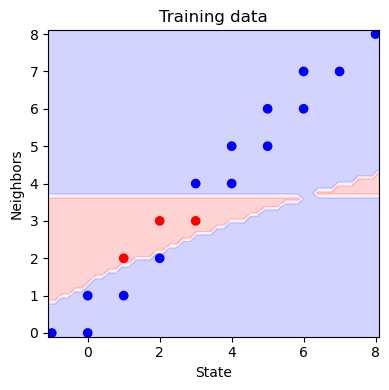

In [33]:
# create a meshgrid
x = np.linspace(-0.1+np.min(x_train2[:, 0]), 0.1+np.max(x_train2[:, 0]), 50)
y = np.linspace(-0.1+np.min(x_train2[:, 1]), 0.1+np.max(x_train2[:, 1]), 50)
X, Y = np.meshgrid(x, y)
# predict the values for the meshgrid

Z = sc2.predict(np.c_[X.ravel(), Y.ravel()])

# plot the decision boundary
plt.contourf(X, Y, Z.reshape(X.shape), cmap="bwr", alpha=0.2)
plt.figsize=(3, 6)
# plot the training data
plt.scatter(x_train2[:, 0], x_train2[:, 1], c=y_train2, cmap="bwr")
plt.ylabel("Neighbors")
plt.xlabel("State")
plt.title("Training data")
save_img("decision_boundary_9_to_2")
plt.show()

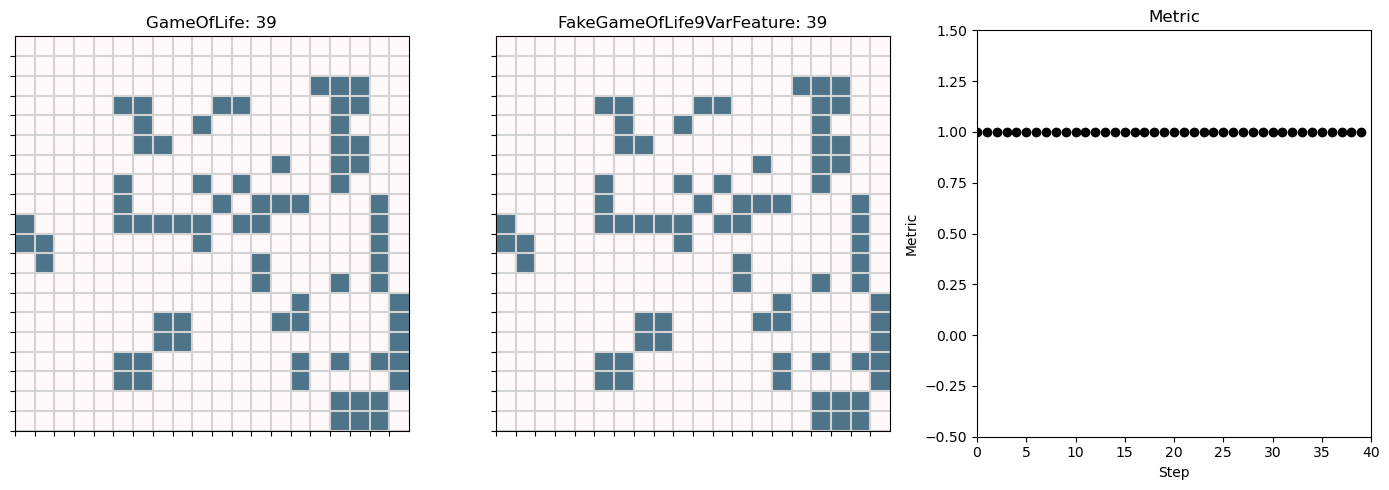

In [34]:
torch.manual_seed(12)
gol = GameOfLife(M=20, N=20)
f_gol_9VarFeature = FakeGameOfLife9VarFeature(state=gol.state,featurizer=st, rule=sc2)

# define a metric to measure the difference between the two games
def metric(gol, f_gol_9VarFeature):
    return 1-torch.mean(torch.abs(gol.state - f_gol_9VarFeature.state), dtype=torch.float).item()


# concatenate a figure with 2 subplots with a line plot to show the metric
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 5))
# create the video
ani = get_animation((gol, f_gol_9VarFeature), fig, (ax1, ax2, ax3), interval=100, frames=40, metric=metric)

# save the video
ani.save("Simulations/game_of_life_9_vars_metric.mp4")